In [19]:
using Distributions
using Statistics
using Roots
using Plots
using DataFrames
using LaTeXStrings
using Optim
using LinearAlgebra
using ForwardDiff

In [20]:
ϕ(x, y; H = 1) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
ϕ′(x, y; H = 1) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
ψ(x, y; K = 1) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
ψ′(x, y; K = 1) = max.(x .- y, 0) .- K .* max.(y .- x, 0)

ψ′ (generic function with 1 method)

In [21]:
function data_generation(N = 10000; H = exp(0.1), K = exp(0.5))
    N = 10000 # number of total observations
    
    # unobserved confounder for external validity
    U = rand(Normal(), N)
    
    # DGP for S₁ and G. They all depend on U.
    S₁ = 5 * (rand(N) .< (0.5 .- 0.3*(U.>0))) .+ 5 
    G = rand(N) .> (1 ./ (1 .+ exp.(-log(H).* (U.>0)))); 
    
    # unobserved confounder for latent unconfoundedness
    V = rand(Normal(), N);
    
    # DGP for Y₁ and D. They all depend on V.
    Y₁ = S₁ + V + randn(N);
    D = similar(G);
    
    # randomization in the experimental sample
    D[G .== 1] = rand((0,1), sum(G .== 1))
    
    # K-latent-confoundedness
    D[G .== 0] = rand(sum(G .== 0)) .> 
    (1 ./ (1 .+ exp.(-log(K).* (V[G .== 0].>0) .- 0.1 .*S₁[G .== 0])))
    
    df = DataFrame(G = G, S1 = S₁, D=D, Y1 = Y₁, S = D.*S₁, Y = D.*Y₁)
end

data_generation (generic function with 2 methods)

In [22]:
function lower(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ1minushat_s1 = find_zero(f(5), 2.0)
    θ1minushat_s2 = find_zero(f(10), 2.0)
    
    return mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ(m, θ1minushat_s1)) + mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ(m, θ1minushat_s2)) 
end

lower (generic function with 1 method)

In [23]:
function upper(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ1plushat_s1 = find_zero(g(5), 2.0)
    θ1plushat_s2 = find_zero(g(10), 2.0)
    
    return mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ′(m, θ1plushat_s1)) + mean((df.D.==1) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ′(m, θ1plushat_s2)) 
end

upper (generic function with 1 method)

In [24]:
function compute_lower_Y1(df; K=1, H=1)
    
    f(s; df = df, K = K) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y; K = K))
    
    θ1minushat_s1 = find_zero(f(5; df = df, K=K), 2.0)
    θ1minushat_s2 = find_zero(f(10; df = df, K=K), 2.0)
    
    μ1minus = find_zero(m -> lower(m; df=df, K=K, H=H), 2.0) / mean(df[df.G .== 0, :D].== 0) - 
    (θ1minushat_s1 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 5) + 
    θ1minushat_s2 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 1) /
    mean(df[df.G .== 0, :D].== 0)
    
    lower_Y1 = mean(df[ (df.G .== 0) .* (df.D .== 1 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 1) +  
        μ1minus* 
        mean(df[df.G .== 0, :D].== 0)
end

compute_lower_Y1 (generic function with 1 method)

In [25]:
function compute_upper_Y1(df; K = exp(0.5), H = exp(0.1))
    
    g(s; df = df, K = K) = m -> mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y; K = K))
    
    θ1plushat_s1 = find_zero(g(5; df = df, K = K), 2.0)
    θ1plushat_s2 = find_zero(g(10; df = df, K = K), 2.0)
    
    μ1plus = find_zero(m -> upper(m; df=df, K=K, H=H), 2.0) / mean(df[df.G .== 0, :D].== 0) - (θ1plushat_s1 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 5) + 
    θ1plushat_s2 * mean(df[ (df.D.==1) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 1) /
    mean(df[df.G .== 0, :D].== 0)
    
    upper_Y1 = mean(df[ (df.G .== 0) .* (df.D .== 1 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 1) +  
        μ1plus* 
        mean(df[df.G .== 0, :D].== 0)
end

compute_upper_Y1 (generic function with 1 method)

In [26]:
function lower2(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ0minushat_s1 = find_zero(f(5), 0.0)
    θ0minushat_s2 = find_zero(f(10), 0.0)
    
    return mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ(m, θ0minushat_s1)) + mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ(m, θ0minushat_s2)) 
end

lower2 (generic function with 1 method)

In [27]:
function upper2(m; K=exp(0.5), H=exp(0.1), df = df)
    ϕ(x, y) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
    ϕ′(x, y) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
    ψ(x, y) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
    ψ′(x, y) = max.(x .- y, 0) .- K .* max.(y .- x, 0)
    
    f(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y))
    g(s) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y))
    
    θ0plushat_s1 = find_zero(g(5), 0.0)
    θ0plushat_s2 = find_zero(g(10), 0.0)
    
    return mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 5) .* ϕ′(m, θ0plushat_s1)) + mean((df.D.==0) .* (df.G .== 1) .*
    (df.S .== 10) .* ϕ′(m, θ0plushat_s2)) 
end

upper2 (generic function with 1 method)

In [28]:
function compute_lower_Y0(df; K=1, H=1)
    
    f(s; df = df, K = K) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ(m, df.Y; K = K))
    
    θ0minushat_s1 = find_zero(f(5; df = df, K=K), 0.0)
    θ0minushat_s2 = find_zero(f(10; df = df, K=K), 0.0)
    
    μ0minus = find_zero(m -> lower2(m; df=df, K=K, H=H), 0.0) / mean(df[df.G .== 0, :D].== 1) - 
    (θ0minushat_s1 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 5) + 
    θ0minushat_s2 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 0) /
    mean(df[df.G .== 0, :D].== 1)
    
    lower_Y0 = mean(df[ (df.G .== 0) .* (df.D .== 0 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 0) +  
        μ0minus* 
        mean(df[df.G .== 0, :D].== 1)
end

compute_lower_Y0 (generic function with 1 method)

In [29]:
function compute_upper_Y0(df; K = exp(0.5), H = exp(0.1))
    
    g(s; df = df, K = K) = m -> mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ s) .* ψ′(m, df.Y; K = K))
    
    θ0plushat_s1 = find_zero(g(5; df = df, K = K), 0.0)
    θ0plushat_s2 = find_zero(g(10; df = df, K = K), 0.0)
    
    μ0plus = find_zero(m -> upper2(m; df=df, K=K, H=H), 0.0) / mean(df[df.G .== 0, :D].== 1) - 
    (θ0plushat_s1 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 5) + 
    θ0plushat_s2 * mean(df[ (df.D.==0) .* (df.G .== 0), :S] .== 10) ) * 
    mean(df[df.G .== 0, :D].== 0) /
    mean(df[df.G .== 0, :D].== 1)
    
    upper_Y0 = mean(df[ (df.G .== 0) .* (df.D .== 0 ), :Y]) * 
        mean(df[df.G .== 0, :D].== 0) +  
        μ0plus* 
        mean(df[df.G .== 0, :D].== 1)
end

compute_upper_Y0 (generic function with 1 method)

In [30]:
function data_generation2(N = 10000; H = exp(0.1), K = exp(0.5))
    τ = 1

    # unobserved confounder for external validity
    U = rand(Normal(), N)

    # DGP for S₁ and G. They all depend on U.
    S₀ = 5 * (rand(N) .< (0.5 .+ 0.15 * (U .> 0))) .+ 5
    S₁ = 5 * (rand(N) .< (0.5 .+ 0.3 * (U .> 0))) .+ 5
    G = rand(N) .< (1 ./ (1 .+ exp.(-log(H) .* (U .> 0))))

    # unobserved confounder for latent unconfoundedness
    V = rand(Normal(), N)

    # DGP for Y₁ and D. They all depend on V.
    Y₀ = S₀ + 5 * V + randn(N)
    Y₁ = Y₀ .+ τ
    D = similar(G)

    # randomization in the experimental sample
    D[G.==1] = rand((0, 1), sum(G .== 1))

    # K-latent-confoundedness
    D[G.==0] = rand(sum(G .== 0)) .<
               (1 ./ (1 .+ exp.(-log(K) .* (V[G.==0] .> 0) - 0.5 .* (U[G .== 0] .> 0) )))

    df = DataFrame(G = G, S1 = S₁, S0 = S₀, D = D, Y1 = Y₁, Y0 = Y₀,
        S = D .* S₁ .+ (1 .- D) .* S₀, Y = D .* Y₁ .+ (1 .- D) .* Y₀)
end

data_generation2 (generic function with 2 methods)

In [31]:
df2 = data_generation2(1000; H = 1, K = 1)

,G,S1,S0,D,Y1,Y0,S,Y
,Bool,Int64,Int64,Bool,Float64,Float64,Int64,Float64
1,1,10,5,0,2.33325,1.33325,5,1.33325
2,0,5,5,1,3.24139,2.24139,5,3.24139
3,1,10,10,1,6.35011,5.35011,10,6.35011
4,1,10,10,0,7.77726,6.77726,10,6.77726
5,1,10,10,1,3.36383,2.36383,10,3.36383
6,1,5,10,1,9.16504,8.16504,5,9.16504
7,1,10,10,1,9.618,8.618,10,9.618
8,1,5,5,1,7.20206,6.20206,5,7.20206
9,0,10,5,0,7.70719,6.70719,5,6.70719


In [38]:
df2 = data_generation2(1000; K = 1.2, H = 1.2)

In [49]:
Ks = exp.(LinRange(0.0, 2, 10))
plot(Ks, [compute_upper_Y1(df2; K = K, H = 1.2) - compute_lower_Y0(df2; K = K, H = 1.2) for K in Ks], xlim = (1, 6), label = "upper bound", lw = 3, linestyle = :dashdot)
plot!(Ks, [compute_lower_Y1(df2; K = K, H = 1.2) - compute_upper_Y0(df2; K = K, H = 1.2) for K in Ks], xlim = (1, 6), label = "lower bound", lw = 3, linestyle = :dashdot)
plot!(Ks, [compute_lower_Y1(df2; K = 1, H = 1) - compute_upper_Y0(df2; K = 1, H = 1) for K in Ks], label = "ACI est.", lw = 3, linestyle = :dashdot)
plot!(leg = :right, xtickfontsize = 18, ytickfontsize = 18, xguidefontsize = 18, yguidefontsize = 18, legendfontsize = 18)
hline!([1], label = "True ATE", lw = 3)
# plot!(title = L"One realization for $\tau$ : true $H = 1.2, K = 1.2$ with $K$ varied$")
plot!(xlabel = L"$K$", ylabel = "estimate")
plot!(size = (800, 800))
savefig("fig1.png")

In [48]:
mean(df2.G)

0.522

In [39]:
using Random
Random.seed!(3)

MersenneTwister(3)

In [20]:
sp = 1.2
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(500; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 500")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^+", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 500
$\tau^-$0.8027683792011951
Std. Dev. of $\tau$0.7120100023236416
$\tau^-$2.0802237104989367
Std. Dev. of $\tau$0.7159826552541644
coverage0.9895


In [26]:
sp = 1.2
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(1000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end


sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 1000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 1000
$\tau^-$0.7975874369603996
Std. Dev. of $\tau$0.505659288339231
$\tau^-$2.0622392296907393
Std. Dev. of $\tau$0.5088518126043838
coverage0.988


In [41]:
sp = 1.2
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(2000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_τ, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_τ, bins = 50, alpha = 0.1, label = "lower bound")
vline!([1], label = "true τ")
plot!(xlabel = "estimate", ylabel = "freq", size = (800, 800))
plot!(leg = :best, xtickfontsize = 18, ytickfontsize = 18, xguidefontsize = 18, yguidefontsize = 18, legendfontsize = 18)
savefig("fig2.png")

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 2000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 2000
$\tau^-$0.7347039385131018
Std. Dev. of $\tau$0.3714857268417802
$\tau^-$1.9867859428540515
Std. Dev. of $\tau$0.3710935932566127
coverage0.996


In [23]:
sp = 1
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(500; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end


sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 500")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 2000
$\tau^-$1.0380950118065349
Std. Dev. of $\tau$0.7318399092243633
$\tau^-$1.0380950118065349
Std. Dev. of $\tau$0.7318399092243633
coverage0.9485


In [24]:
sp = 1
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(1000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end


sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 1000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 1000
$\tau^-$1.0390572634113282
Std. Dev. of $\tau$0.49570496103718037
$\tau^-$1.0390572634113282
Std. Dev. of $\tau$0.49570496103718037
coverage0.9455


In [25]:
sp = 1
upper_bound_τ = []
oracle_τ = []
lower_bound_τ = []

for _ in 1:2000
    df2 = data_generation2(2000; K = sp, H = sp)
    push!(upper_bound_τ, compute_upper_Y1(df2; K = sp, H = sp) - compute_lower_Y0(df2; K = sp, H = sp))
    push!(lower_bound_τ, compute_lower_Y1(df2; K = sp, H = sp) - compute_upper_Y0(df2; K = sp, H = sp))
    push!(oracle_τ, mean(df2[df2.G.==0, :Y1] - df2[df2.G.==0, :Y0]))
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 2000")
println(L"\tau^-", mean(lower_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_l)
println(L"\tau^-", mean(upper_bound_τ))
println(L"Std. Dev. of $\tau$", sigma_h)
println("coverage", mean(upper_bound_τ .+ 1.96 * sigma_h .> 1 .> lower_bound_τ .- 1.96 * sigma_l))

n = 2000
$\tau^-$1.0290152371886407
Std. Dev. of $\tau$0.3569225372080426
$\tau^-$1.0290152371886407
Std. Dev. of $\tau$0.3569225372080426
coverage0.947


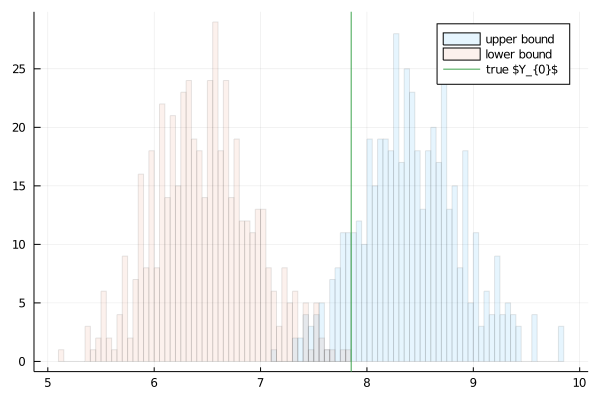

In [16]:
upper_bound_Y0 = []
oracle_Y0 = []
lower_bound_Y0 = []

for i in 1:500
    df2 = data_generation2(800; K = 1.5, H = 1.5)
    push!(upper_bound_Y0, compute_upper_Y0(df2; K = 1.5, H = 1.5))
    push!(lower_bound_Y0, compute_lower_Y0(df2; K = 1.5, H = 1.5))
    push!(oracle_Y0, mean(df2[df2.G.==0, :Y0]))
end

histogram(upper_bound_Y0, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_Y0, bins = 50, alpha = 0.1, label = "lower bound")
vline!([mean(oracle_Y0)], label = L"true $Y_{0}$")

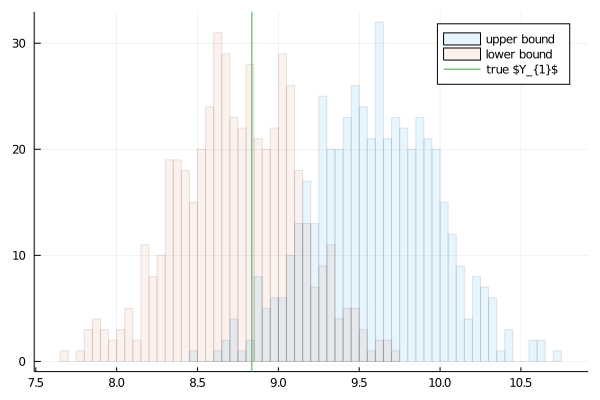

In [17]:
upper_bound_Y1 = []
oracle_Y1 = []
lower_bound_Y1 = []

for i in 1:500
    df2 = data_generation2(800; K = 1.5, H = 1.5)
    push!(upper_bound_Y1, compute_upper_Y1(df2; K = 1.5, H = 1.5))
    push!(lower_bound_Y1, compute_lower_Y1(df2; K = 1.5, H = 1.5))
    push!(oracle_Y1, mean(df2[df2.G.==0, :Y1]))
end

histogram(upper_bound_Y1, bins = 50, alpha = 0.1, label = "upper bound")
histogram!(lower_bound_Y1, bins = 50, alpha = 0.1, label = "lower bound")
vline!([mean(oracle_Y1)], label = L"true $Y_{1}$")

## Confidence Interval

In [96]:
ϕ(x, y; H = 1) = max.(y .- x, 0) .- H .* max.(x .- y, 0)
ϕ′(x, y; H = 1) = max.(x .- y, 0) .- H .* max.(y .- x, 0)
ψ(x, y; K = 1) = max.(y .- x, 0) .- K .* max.(x .- y, 0)
ψ′(x, y; K = 1) = max.(x .- y, 0) .- K .* max.(y .- x, 0)

ψ′ (generic function with 1 method)

In [97]:
function moment_τ_bds(param, data; K = 1, H = 1)
    df = data
    p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0 = param

    [mean(p1 .- df[df.G.==0, :D])
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ11, df.Y; K = K))
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ12, df.Y; K = K))
        mean((df.D .== 1) .* (df.G .== 1) .* (df.S .≈ 5) .* ϕ(ζ1, θ11; H = H)) + mean((df.D .== 1) .* (df.G .== 1) .* (df.S .≈ 10) .* ϕ(ζ1, θ12; H = H))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ′(θ01, df.Y; K = K))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ′(θ02, df.Y; K = K))
        mean((df.D .== 0) .* (df.G .== 1) .* (df.S .≈ 5) .* ϕ′(ζ0, θ01; H = H)) + mean((df.D .== 0) .* (df.G .== 1) .* (df.S .≈ 10) .* ϕ′(ζ0, θ02; H = H))
        q1 - mean(df[(df.G.==0).*(df.D.==1), :S] .== 5)
        # q2 - mean(df[ (df.G.==0) .* (df.D .==1), :S] .== 10);
        r1 - mean(df[(df.G.==0).*(df.D.==0), :S] .== 5)
        # r2 - mean(df[ (df.G.==0) .* (df.D .==0), :S] .== 10);
        mean((df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.Y .- m0))]
end

moment_τ_bds (generic function with 1 method)

In [98]:
function cov_moment_τ_bds(param, data; K = 1, H = 1)
    df = data
    p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0 = param

    n = size(df, 1)

    mom = hcat((df.G .== 0) .* (p1 .- df[:, :D]),
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ11, df.Y; K = K),
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ12, df.Y; K = K),
        (df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ1, θ11; H = H) + (df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ1, θ12; H = H),
        (df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ′(θ01, df.Y; K = K),
        (df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ′(θ02, df.Y; K = K),
        (df.D .== 0) .* (df.G .== 1) .* (df.S .== 5) .* ϕ′(ζ0, θ01;H = H) + (df.D .== 0) .* (df.G .== 1) .* (df.S .== 10) .* ϕ′(ζ0, θ02;H = H),
        (df.G .== 0) .* (df.D .== 1) .* (q1 .- (df[:, :S] .== 5)),
        # (df.G .== 0) .* (df.D .== 1) .* (q2 .- (df[:, :S] .== 10)),
        (df.G .== 0) .* (df.D .== 0) .* (r1 .- (df[:, :S] .== 5)),
        # (df.G .== 0) .* (df.D .== 0) .* (r2 .- (df[:, :S] .== 10)),
        (df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1),
        (df.D .== 0) .* (df.G .== 0) .* (df.Y .- m0))

    result = zeros(11, 11)
    for i in 1:n
        result += 1 / n * mom[i, :] * mom[i, :]'
    end

    result
end

cov_moment_τ_bds (generic function with 1 method)

In [99]:
function CI_τ_lb(data; K = 1, H = 1)

    param_init = [0.5, 5.0, 10.0, 7.5, 5.0, 10.0, 7.5, 0.3, 0.3, 7.0, 8.0]

    loss(param) = norm(moment_τ_bds(param, data; K = K, H = H))
    result = Optim.optimize(loss, param_init)
    param_est = result.minimizer

    τ_lb_func((p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0)) = (ζ1 - p1 * (q1 * θ11 + (1 - q1) * θ12)) + p1 * m1 -
    ((ζ0 - (1 - p1) * (r1 * θ01 + (1 - r1) * θ02)) + (1 - p1) * m0)

    G = ForwardDiff.jacobian(x -> moment_τ_bds(x, data; K = K, H = H), param_est)[1:11, 1:11]
    V = cov_moment_τ_bds(param_est, data; K = K, H = H)[1:11, 1:11]

    grad_τ_lb = ForwardDiff.gradient(τ_lb_func, param_est[1:11])

    asym_var_τ_lb = grad_τ_lb' * inv(G' * inv(V) * G) * grad_τ_lb

    std_err_τ_lb = sqrt(asym_var_τ_lb) / sqrt(size(df2, 1))

    est = τ_lb_func(param_est[1:11])

    #return compute_lower_Y1(df2; K = K, H = H) - compute_upper_Y0(df2; K = K, H = H), std_err_τ_lb
    return est, std_err_τ_lb
end

CI_τ_lb (generic function with 1 method)

In [100]:
using Random
Random.seed!(3)
df2 = data_generation2(2000; K = 1.2, H = 1.2);
@show CI_τ_lb(df2; K = 1.2, H = 1.2);
@show compute_lower_Y1(df2; K = 1.2, H = 1.2) - compute_upper_Y0(df2; K = 1.2, H = 1.2);

CI_τ_lb(df2; K = 1.2, H = 1.2) = (0.8650338652282947, 0.3668000546008375)
compute_lower_Y1(df2; K = 1.2, H = 1.2) - compute_upper_Y0(df2; K = 1.2, H = 1.2) = 0.8650340159850956


In [101]:
sp = 1.2
lower_bound_τ = []
lower_bound_std_err_τ = []

for _ in 1:500
    df2 = data_generation2(2000; K = sp, H = sp)
    try
        lower_est, lower_std_err = CI_τ_lb(df2; K = sp, H = sp)
        push!(lower_bound_τ, lower_est)
        push!(lower_bound_std_err_τ, lower_std_err)
    catch
        println("Fails")
    end
end

In [102]:
println("n = 2000")
println(L"\tau^- :", mean(lower_bound_τ))
println("coverage: ", mean(1 .> lower_bound_τ .- 1.96 * lower_bound_std_err_τ))
length(lower_bound_τ)

n = 2000
$\tau^- :$0.7209560521281725
coverage: 0.996


500

In [122]:
function moment_τ_upper_bds(param, data; K = 1, H = 1)
    df = data
    p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0 = param

    [p1 - mean(df[df.G.==0, :D])
        mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ01, df.Y; K = K))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ02, df.Y; K = K))
        mean((df.D .== 0) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ0, θ01; H = H)) + mean((df.D .== 0) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ0, θ02; H = H))
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ′(θ11, df.Y; K = K))
        mean((df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ′(θ12, df.Y; K = K))
        mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ′(ζ1, θ11; H = H)) + mean((df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ′(ζ1, θ12; H = H))
        q1 - mean(df[(df.G.==0).*(df.D.==1), :S] .== 5)
        # q2 - mean(df[ (df.G.==0) .* (df.D .==1), :S] .== 10);
        r1 - mean(df[(df.G.==0).*(df.D.==0), :S] .== 5)
        # r2 - mean(df[ (df.G.==0) .* (df.D .==0), :S] .== 10);
        mean((df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1))
        mean((df.D .== 0) .* (df.G .== 0) .* (df.Y .- m0))]
end

moment_τ_upper_bds (generic function with 1 method)

In [123]:
function cov_moment_τ_upper_bds(param, data; K = 1, H = 1)
    df = data
    p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0 = param

    n = size(df, 1)

    mom = hcat((df.G .== 0) .* (p1 .- df[:, :D]),
        (df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ(θ01, df.Y; K = K),
        (df.D .== 0) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ(θ02, df.Y; K = K),
        (df.D .== 0) .* (df.G .== 1) .* (df.S .== 5) .* ϕ(ζ0, θ01; H = H) + (df.D .== 0) .* (df.G .== 1) .* (df.S .== 10) .* ϕ(ζ0, θ02; H = H),
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 5) .* ψ′(θ11, df.Y; K = K),
        (df.D .== 1) .* (df.G .== 0) .* (df.S .≈ 10) .* ψ′(θ12, df.Y; K = K),
        (df.D .== 1) .* (df.G .== 1) .* (df.S .== 5) .* ϕ′(ζ1, θ11;H = H) + (df.D .== 1) .* (df.G .== 1) .* (df.S .== 10) .* ϕ′(ζ1, θ12;H = H),
        (df.G .== 0) .* (df.D .== 1) .* (q1 .- (df[:, :S] .== 5)),
        # (df.G .== 0) .* (df.D .== 1) .* (q2 .- (df[:, :S] .== 10)),
        (df.G .== 0) .* (df.D .== 0) .* (r1 .- (df[:, :S] .== 5)),
        # (df.G .== 0) .* (df.D .== 0) .* (r2 .- (df[:, :S] .== 10)),
        (df.D .== 1) .* (df.G .== 0) .* (df.Y .- m1),
        (df.D .== 0) .* (df.G .== 0) .* (df.Y .- m0))

    result = zeros(11, 11)
    for i in 1:n
        result += 1 / n * mom[i, :] * mom[i, :]'
    end

    result
end

cov_moment_τ_upper_bds (generic function with 1 method)

In [125]:
function CI_τ_ub(data; K = 1, H = 1)

    param_init = [0.5, 5.0, 10.0, 7.5, 5.0, 10.0, 7.5, 0.3, 0.3, 7.0, 8.0]

    loss(param) = norm(moment_τ_upper_bds(param, data; K = K, H = H))
    result = Optim.optimize(loss, param_init)
    param_est = result.minimizer

    τ_ub_func((p1, θ11, θ12, ζ1, θ01, θ02, ζ0, q1, r1, m1, m0)) = (ζ1 - p1 * (q1 * θ11 + (1 - q1) * θ12)) + p1 * m1 -
    ((ζ0 - (1 - p1) * (r1 * θ01 + (1 - r1) * θ02)) + (1 - p1) * m0)

    G = ForwardDiff.jacobian(x -> moment_τ_upper_bds(x, data; K = K, H = H), param_est)[1:11, 1:11]
    V = cov_moment_τ_upper_bds(param_est, data; K = K, H = H)[1:11, 1:11]

    grad_τ_ub = ForwardDiff.gradient(τ_ub_func, param_est[1:11])

    asym_var_τ_ub = grad_τ_ub' * inv(G' * inv(V) * G) * grad_τ_ub

    std_err_τ_ub = sqrt(asym_var_τ_ub) / sqrt(size(df2, 1))

    est = τ_ub_func(param_est[1:11])

    #return compute_upper_Y1(df2; K = K, H = H) - compute_lower_Y0(df2; K = K, H = H), std_err_τ_lb
    return est, std_err_τ_ub
end

CI_τ_ub (generic function with 1 method)

In [127]:
df2 = data_generation2(2000; K = 1.2, H = 1.2);
@show CI_τ_ub(df2; K = 1.2, H = 1.2)
@show compute_upper_Y1(df2; K = 1.2, H = 1.2) - compute_lower_Y0(df2; K = 1.2, H = 1.2)

CI_τ_ub(df2; K = 1.2, H = 1.2) = (2.1273519318664125, 0.3680065734404517)
compute_upper_Y1(df2; K = 1.2, H = 1.2) - compute_lower_Y0(df2; K = 1.2, H = 1.2) = 2.1273519783603314


2.1273519783603314

## Simulation Results

In [128]:
sp = 1
lower_bound_τ = []
lower_bound_std_err_τ = []
upper_bound_τ = []
upper_bound_std_err_τ = []

for _ in 1:2000
    df2 = data_generation2(500; K = sp, H = sp)
    try
        lower_est, lower_std_err = CI_τ_lb(df2; K = sp + 0.01, H = sp + 0.01)
        push!(lower_bound_τ, lower_est)
        push!(lower_bound_std_err_τ, lower_std_err)

        upper_est, upper_std_err = CI_τ_ub(df2; K = sp + 0.01, H = sp + 0.01)
        push!(upper_bound_τ, upper_est)
        push!(upper_bound_std_err_τ, upper_std_err)
    catch
        println("Fails")
    end
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 500")
println(L"\tau^-: ", mean(lower_bound_τ))
println(L"\sigma^-: ", mean(lower_bound_std_err_τ))
println(L"Std. Dev. of $\tau$: ", sigma_l)
println(L"\tau^+ : ", mean(upper_bound_τ))
println(L"\sigma^+ :", mean(upper_bound_std_err_τ))
println(L"Std. Dev. of $\tau$ :", sigma_h)
println("coverage: ", mean(upper_bound_τ .+ 1.96 * upper_bound_std_err_τ .> 1 .> lower_bound_τ .- 1.96 * lower_bound_std_err_τ))

n = 500
$\tau^-: $1.0208153493495769
$\sigma^-: $0.7257933652566325
Std. Dev. of $\tau$: 0.7271165983402392
$\tau^+ : $1.0908893062364389
$\sigma^+ :$0.7259253734198631
Std. Dev. of $\tau$ :0.7272963994931668
coverage: 0.949


In [134]:
sp = 1
lower_bound_τ = []
lower_bound_std_err_τ = []
upper_bound_τ = []
upper_bound_std_err_τ = []

for _ in 1:2000
    df2 = data_generation2(1000; K = sp, H = sp)
    try
        lower_est, lower_std_err = CI_τ_lb(df2; K = sp + 0.01, H = sp + 0.01)
        push!(lower_bound_τ, lower_est)
        push!(lower_bound_std_err_τ, lower_std_err)

        upper_est, upper_std_err = CI_τ_ub(df2; K = sp + 0.01, H = sp + 0.01)
        push!(upper_bound_τ, upper_est)
        push!(upper_bound_std_err_τ, upper_std_err)
    catch
        println("Fails")
    end
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 1000")
println(L"\tau^-: ", mean(lower_bound_τ))
println(L"\sigma^-: ", mean(lower_bound_std_err_τ))
println(L"Std. Dev. of $\tau$: ", sigma_l)
println(L"\tau^+ : ", mean(upper_bound_τ))
println(L"\sigma^+ :", mean(upper_bound_std_err_τ))
println(L"Std. Dev. of $\tau$ :", sigma_h)
println("coverage: ", mean(upper_bound_τ .+ 1.96 * upper_bound_std_err_τ .> 1 .> lower_bound_τ .- 1.96 * lower_bound_std_err_τ))

Fails
Fails
Fails
Fails
Fails
Fails
Fails
Fails
Fails
Fails


In [130]:
sp = 1
lower_bound_τ = []
lower_bound_std_err_τ = []
upper_bound_τ = []
upper_bound_std_err_τ = []

for _ in 1:2000
    df2 = data_generation2(2000; K = sp, H = sp)
    try
        lower_est, lower_std_err = CI_τ_lb(df2; K = sp + 0.01, H = sp + 0.01)
        push!(lower_bound_τ, lower_est)
        push!(lower_bound_std_err_τ, lower_std_err)

        upper_est, upper_std_err = CI_τ_ub(df2; K = sp + 0.01, H = sp + 0.01)
        push!(upper_bound_τ, upper_est)
        push!(upper_bound_std_err_τ, upper_std_err)
    catch
        println("Fails")
    end
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 2000")
println(L"\tau^-: ", mean(lower_bound_τ))
println(L"\sigma^-: ", mean(lower_bound_std_err_τ))
println(L"Std. Dev. of $\tau$: ", sigma_l)
println(L"\tau^+ : ", mean(upper_bound_τ))
println(L"\sigma^+ :", mean(upper_bound_std_err_τ))
println(L"Std. Dev. of $\tau$ :", sigma_h)
println("coverage: ", mean(upper_bound_τ .+ 1.96 * upper_bound_std_err_τ .> 1 .> lower_bound_τ .- 1.96 * lower_bound_std_err_τ))

n = 2000
$\tau^-: $0.9880459426915641
$\sigma^-: $0.3617527465776559
Std. Dev. of $\tau$: 0.35202905166044696
$\tau^+ : $1.0568571004448248
$\sigma^+ :$0.36178054346273714
Std. Dev. of $\tau$ :0.3520825339401961
coverage: 0.9665


In [131]:
sp = 1.2
lower_bound_τ = []
lower_bound_std_err_τ = []
upper_bound_τ = []
upper_bound_std_err_τ = []

for _ in 1:2000
    df2 = data_generation2(500; K = sp, H = sp)
    try
        lower_est, lower_std_err = CI_τ_lb(df2; K = sp, H = sp)
        push!(lower_bound_τ, lower_est)
        push!(lower_bound_std_err_τ, lower_std_err)

        upper_est, upper_std_err = CI_τ_ub(df2; K = sp, H = sp)
        push!(upper_bound_τ, upper_est)
        push!(upper_bound_std_err_τ, upper_std_err)
    catch
        println("Fails")
    end
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 500")
println(L"\tau^-: ", mean(lower_bound_τ))
println(L"\sigma^-: ", mean(lower_bound_std_err_τ))
println(L"Std. Dev. of $\tau$: ", sigma_l)
println(L"\tau^+ : ", mean(upper_bound_τ))
println(L"\sigma^+ :", mean(upper_bound_std_err_τ))
println(L"Std. Dev. of $\tau$ :", sigma_h)
println("coverage: ", mean(upper_bound_τ .+ 1.96 * upper_bound_std_err_τ .> 1 .> lower_bound_τ .- 1.96 * lower_bound_std_err_τ))

n = 500
$\tau^-: $0.7044979357179911
$\sigma^-: $0.7449629729770909
Std. Dev. of $\tau$: 0.7456269407472771
$\tau^+ : $1.9850249925581098
$\sigma^+ :$0.744634389156857
Std. Dev. of $\tau$ :0.7486905299267184
coverage: 0.989


In [132]:
sp = 1.2
lower_bound_τ = []
lower_bound_std_err_τ = []
upper_bound_τ = []
upper_bound_std_err_τ = []

for _ in 1:2000
    df2 = data_generation2(1000; K = sp, H = sp)
    try
        lower_est, lower_std_err = CI_τ_lb(df2; K = sp, H = sp)
        push!(lower_bound_τ, lower_est)
        push!(lower_bound_std_err_τ, lower_std_err)

        upper_est, upper_std_err = CI_τ_ub(df2; K = sp, H = sp)
        push!(upper_bound_τ, upper_est)
        push!(upper_bound_std_err_τ, upper_std_err)
    catch
        println("Fails")
    end
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 1000")
println(L"\tau^-: ", mean(lower_bound_τ))
println(L"\sigma^-: ", mean(lower_bound_std_err_τ))
println(L"Std. Dev. of $\tau$: ", sigma_l)
println(L"\tau^+ : ", mean(upper_bound_τ))
println(L"\sigma^+ :", mean(upper_bound_std_err_τ))
println(L"Std. Dev. of $\tau$ :", sigma_h)
println("coverage: ", mean(upper_bound_τ .+ 1.96 * upper_bound_std_err_τ .> 1 .> lower_bound_τ .- 1.96 * lower_bound_std_err_τ))

n = 1000
$\tau^-: $0.730555357845266
$\sigma^-: $0.5249438826751109
Std. Dev. of $\tau$: 0.5180486284643964
$\tau^+ : $1.9930682337124848
$\sigma^+ :$0.5246064308360863
Std. Dev. of $\tau$ :0.5169157645873588
coverage: 0.992


In [133]:
sp = 1.2
lower_bound_τ = []
lower_bound_std_err_τ = []
upper_bound_τ = []
upper_bound_std_err_τ = []

for _ in 1:2000
    df2 = data_generation2(2000; K = sp, H = sp)
    try
        lower_est, lower_std_err = CI_τ_lb(df2; K = sp, H = sp)
        push!(lower_bound_τ, lower_est)
        push!(lower_bound_std_err_τ, lower_std_err)

        upper_est, upper_std_err = CI_τ_ub(df2; K = sp, H = sp)
        push!(upper_bound_τ, upper_est)
        push!(upper_bound_std_err_τ, upper_std_err)
    catch
        println("Fails")
    end
end

sigma_l = std(lower_bound_τ)
sigma_h = std(upper_bound_τ)

println("n = 2000")
println(L"\tau^-: ", mean(lower_bound_τ))
println(L"\sigma^-: ", mean(lower_bound_std_err_τ))
println(L"Std. Dev. of $\tau$: ", sigma_l)
println(L"\tau^+ : ", mean(upper_bound_τ))
println(L"\sigma^+ :", mean(upper_bound_std_err_τ))
println(L"Std. Dev. of $\tau$ :", sigma_h)
println("coverage: ", mean(upper_bound_τ .+ 1.96 * upper_bound_std_err_τ .> 1 .> lower_bound_τ .- 1.96 * lower_bound_std_err_τ))

n = 2000
$\tau^-: $0.7486867110637285
$\sigma^-: $0.37044651813513085
Std. Dev. of $\tau$: 0.3757369770595559
$\tau^+ : $2.0009827166891605
$\sigma^+ :$0.3702531464205175
Std. Dev. of $\tau$ :0.3748736606903644
coverage: 0.9955
